In [182]:
!pip install gensim --upgrade
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install tensorflow



Requirement already up-to-date: gensim in c:\users\raresgeorge\anaconda3\lib\site-packages (4.0.1)
Requirement already up-to-date: keras in c:\users\raresgeorge\anaconda3\lib\site-packages (2.4.3)
Requirement already up-to-date: pandas in c:\users\raresgeorge\anaconda3\lib\site-packages (1.2.4)


In [183]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools



In [184]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RaresGeorge\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [185]:
# DATASET
DATASET_COLUMNS = ["public_id", "title", "text", "our_rating"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 100
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 700
EPOCHS = 8
BATCH_SIZE = 16

# SENTIMENT
FALSE = "FALSE"
TRUE = "TRUE"
PARTIAL = "partially false"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [186]:

df = pd.read_csv('combined_all.csv')
df.fillna('', inplace=True)
#df.drop(columns=df.columns[4],inplace=True)
df.head()
df

,public_id,title,text,our rating
0,f2182a54,HUGE! Attorney Sidney Powell CONFIRMS Alleged ...,Last week Rep. Louie Gohmert told Chris Salced...,false
1,c5175d8d,Paul Ryan’s Worst Ally - The New York Times,WHATEVER drama plays out when Republicans meet...,true
2,213a870b,"You Can Get Jail Time Or $3,000 Fine For Not W...",Source page URL Title You Can Get Jail Time O...,false
3,392886ea,Antifa gearing up for false flag violence disg...,With merchants in Democrat-run cities boarding...,false
4,bc6d5d55,Remarks by President Biden on the Administrati...,State Dining Room 4:22 P.M. EST THE PRESIDEN...,partially false
...,...,...,...,...
945,168e5898,NHS fails thousands of new mothers with post-n...,Increased atmospheric carbon dioxide has helpe...,other
946,94aabd16,Boris Johnson vows to compensate for 'SNP inad...,Boris Johnson has vowed to bring forward measu...,partially false
947,1a6a1a97,Nothing On This Earth Will Make President Buha...,The number of children being considered for ad...,true
948,842ac903,,Rep. Leon Young figures the Wisconsin Legislat...,false


In [187]:
decode_map = {"false": 2, "true": 4, "partially false": 0, "other":6}
def decode_sentiment(label):
    return decode_map[label]

In [188]:
%%time
df["our rating"] = df["our rating"].apply(lambda x: decode_sentiment(x))

Wall time: 998 µs


Text(0.5, 1.0, 'Dataset labels distribuition')

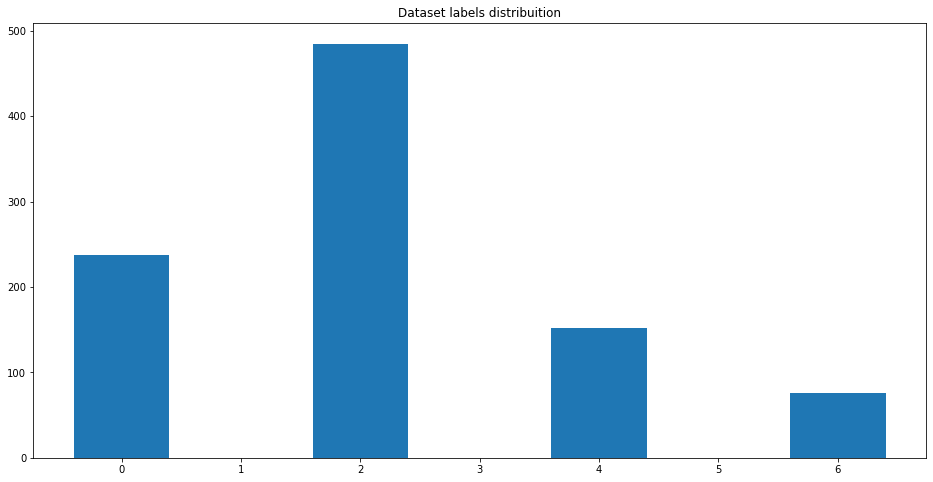

In [189]:
target_cnt = Counter(df["our rating"])

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [190]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [191]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [192]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1.48 s


In [193]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 760
TEST size: 190


In [194]:
%%time
documents = [_text.split() for _text in df_train.text] 


Wall time: 32.9 ms


In [195]:
w2v_model = gensim.models.word2vec.Word2Vec( 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


In [196]:
w2v_model.build_vocab(documents)

In [197]:

vocab_size   = len(w2v_model.wv) 
print("Vocab size", vocab_size)

Vocab size 5176


In [198]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

Wall time: 3.27 s


(8209704, 9956192)

In [199]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 25675
Wall time: 267 ms


In [200]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
x_train

Wall time: 225 ms


array([[    0,     0,     0, ...,   498,   164,  4821],
       [    0,     0,     0, ...,   859,   291,   884],
       [ 6100, 15885,   659, ..., 12020,   868,    35],
       ...,
       [    0,     0,     0, ...,     4,    88,   395],
       [    0,     0,     0, ...,  5136,  4520,  3157],
       [    0,     0,     0, ...,   255,   239,   387]])

In [201]:
labels = df_train["our rating"].unique().tolist()
labels

[6, 0, 2, 4]

In [202]:
encoder = LabelEncoder()
encoder.fit(df_train["our rating"].tolist())

y_train = encoder.transform(df_train["our rating"].tolist())
y_test = encoder.transform(df_test["our rating"].tolist())
y_train

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

#print("y_train",y_train.shape)
#print("y_test",y_test.shape)

In [203]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (760, 700)
y_train (760, 1)

x_test (190, 700)
y_test (190, 1)


In [204]:
y_train[:10]

array([[3],
       [0],
       [1],
       [2],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1]], dtype=int64)

In [205]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(25675, 100)


In [206]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [207]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 700, 100)          2567500   
_________________________________________________________________
dropout_13 (Dropout)         (None, 700, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 404       
Total params: 2,648,304
Trainable params: 80,804
Non-trainable params: 2,567,500
_________________________________________________________________


In [208]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [209]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [222]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,callbacks=callbacks
                    )

Epoch 1/8
43/43 [==============================] - 58s 1s/step - loss: 0.5580 - accuracy: 0.7997 - val_loss: 1.6159 - val_accuracy: 0.5263
Epoch 2/8
43/43 [==============================] - 58s 1s/step - loss: 0.5526 - accuracy: 0.8070 - val_loss: 1.6292 - val_accuracy: 0.5395
Epoch 3/8
43/43 [==============================] - 58s 1s/step - loss: 0.5298 - accuracy: 0.8114 - val_loss: 1.6350 - val_accuracy: 0.5526
Epoch 4/8
43/43 [==============================] - 58s 1s/step - loss: 0.5311 - accuracy: 0.7865 - val_loss: 1.6844 - val_accuracy: 0.5526
Epoch 5/8
43/43 [==============================] - 58s 1s/step - loss: 0.5305 - accuracy: 0.8070 - val_loss: 1.6717 - val_accuracy: 0.5263
Epoch 6/8
43/43 [==============================] - 58s 1s/step - loss: 0.5253 - accuracy: 0.7953 - val_loss: 1.6845 - val_accuracy: 0.5132
Epoch 7/8
43/43 [==============================] - 59s 1s/step - loss: 0.5000 - accuracy: 0.8041 - val_loss: 1.6881 - val_accuracy: 0.5132
Epoch 8/8
43/43 [==========

In [223]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()

print("ACCURACY:",score[1])
print("LOSS:",score[0])

12/12 [==============================] - 2s 181ms/step - loss: 1.4815 - accuracy: 0.5211

ACCURACY: 0.5210526585578918
LOSS: 1.481467843055725
Wall time: 2.21 s


In [224]:
pred = model.predict_classes(x_test)
pred

array([1, 1, 1, 1, 1, 0, 1, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 3,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 2, 1,
       1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 3,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 0,
       0, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 1, 0, 0], dtype=int64)

<AxesSubplot:>

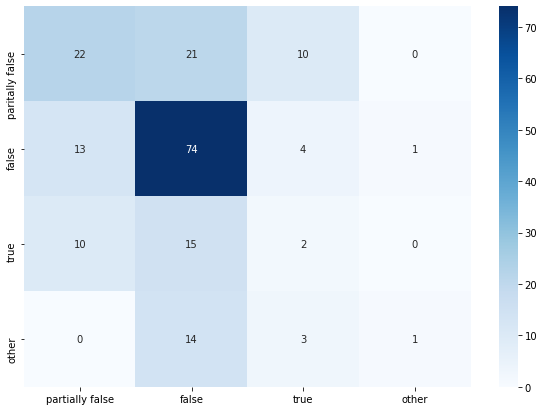

In [225]:
import seaborn as sn
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=['paritally false', 'false', 'true', 'other'], 
                     columns=['partially false', 'false', 'true', 'other'])
plt.figure(figsize = (10, 7))
sn.heatmap(df_cm, cmap="Blues", annot=True)

In [226]:
df1=pd.read_csv('Task3a_testing.csv')
df1.head()
df1

,public_id,text,title,our rating
0,81a67c96,Former state House Majority Leader Adam Hasner...,- The Washington Post,NaN
1,6e5ec6fb,"Editor’s note: Subsequent to this article, VTD...",Rubio Comments on Iran Nuclear Deal,NaN
2,d9cd4895,The hypocritical Lib Dems want to ignore the r...,Climate Alarmists Caught Manipulating Temperat...,NaN
3,4a1a9b9f,Urgent action to boost the number of children ...,Who are the arsonists setting rural fires in W...,NaN
4,6d16fa40,By Ken Allen AFSCME Council 75 represents the ...,"Diabetes prescriptions now cost NHS £1bn, figu...",NaN
...,...,...,...,...
359,3d1a155a,"There is nothing we can do about it, except to...","The Sea Is Rising, but Not Because of Climate ...",NaN
360,6c425155,Increased atmospheric carbon dioxide has helpe...,The Phony War Against CO2\n,NaN
361,f0669fad,Considering the importance of immunity boostin...,"Government of India Ministry of Ayurveda, Yoga...",NaN
362,8060b507,"Even if world temperatures rise, the appropria...",Climate Change Isn’t the End of the World,NaN


In [227]:
df1.text = df1.text.apply(lambda x: preprocess(x))

In [228]:
x1_test = pad_sequences(tokenizer.texts_to_sequences(df1.text), maxlen=SEQUENCE_LENGTH)

In [229]:
pred1 = model.predict_classes(x1_test)
pred1

C:\Users\RaresGeorge\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1, 1, 3, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 0, 1, 0, 1, 2, 1,
       2, 2, 0, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 0, 1, 0, 1, 2,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 0, 0, 2, 1, 0, 2, 2, 1, 2,
       2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 2,
       0, 0, 2, 2, 2, 0, 0, 2, 1, 1, 1, 2, 1, 2, 0, 1, 2, 1, 0, 0, 0, 0,
       2, 2, 1, 0, 2, 2, 1, 2, 1, 0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 2, 0, 2, 1, 2, 1, 2, 2, 1, 3, 2,
       1, 0, 0, 0, 2, 1, 2, 2, 0, 1, 1, 1, 1, 2, 2,

In [230]:
preds=[]
for i in pred1:
    if i==1:
         preds.append('false')
    if i==2:
        preds.append('true')
    if i==3:
        preds.append('other')
    if i==0:
        preds.append('partially false')
preds
        

['partially false',
 'false',
 'false',
 'false',
 'true',
 'partially false',
 'true',
 'true',
 'false',
 'partially false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'other',
 'partially false',
 'partially false',
 'false',
 'false',
 'false',
 'false',
 'partially false',
 'false',
 'false',
 'other',
 'false',
 'other',
 'false',
 'true',
 'false',
 'false',
 'false',
 'false',
 'false',
 'true',
 'false',
 'partially false',
 'false',
 'partially false',
 'false',
 'true',
 'false',
 'true',
 'true',
 'partially false',
 'false',
 'partially false',
 'false',
 'false',
 'false',
 'true',
 'false',
 'partially false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'true',
 'false',
 'false',
 'false',
 'true',
 'true',
 'partially false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'partially false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'false',
 'other',
 'false',
 'partially false',
 'false',
 'partially false',
 '

In [232]:
df_out=pd.DataFrame()
df_out['public_id']=df1['public_id']
df_out['predicted_rating']=preds
df_out.to_csv('predictionsFinal3.csv', index=False)